In [10]:
from huggingface_hub import login
import os
from dotenv import load_dotenv

# Paste your token here (or load from environment variable)
hf_token = os.getenv("HF_ACCESS_TOKEN")
login(token=hf_token)

In [11]:
load_dotenv()
os.getenv("GEMMA3_PATH")

In [9]:
# llm_loader/llm_wrapper.py

import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline
from transformers import AutoProcessor, AutoModelForImageTextToText, Gemma3ForConditionalGeneration

class VLLMWrapper:
    def __init__(self, model_path, pipeline_kwargs=None):
        self.model_path = model_path
        self.processor = None
        self.model = None
        self._load()
        # self._build_pipeline(pipeline_kwargs or {})

    def _load(self):

        self.model = Gemma3ForConditionalGeneration.from_pretrained(
            self.model_path, device_map="auto"
        ).eval()

        self.processor = AutoProcessor.from_pretrained(self.model_path)

    def _build_pipeline(self, pipeline_kwargs):
        default_kwargs = {
            "task": "text-generation",
            "model": self.model,
            "tokenizer": self.tokenizer,
            "truncation": True,
            "eos_token_id": self.tokenizer.eos_token_id,
            "pad_token_id": self.tokenizer.eos_token_id,
        }
        default_kwargs.update(pipeline_kwargs)
        self.pipe = pipeline(**default_kwargs)

    def __call__(self, image, prompt: str, **generate_kwargs):
        messages = [
            {
                "role": "system",
                "content": [
                    {"type": "text", "text": "You are a helpful assistant."}
                ]
            },
            {
                "role": "user", "content": [
                    {"type": "image", "image": image},
                    {"type": "text", "text": prompt},
                ]
            },
        ]

        inputs = self.processor.apply_chat_template(
            messages, add_generation_prompt=True, tokenize=True,
            return_dict=True, return_tensors="pt"
        ).to(self.model.device, dtype=torch.bfloat16)

        input_len = inputs["input_ids"].shape[-1]

        with torch.inference_mode():
            generation = self.model.generate(**inputs, max_new_tokens=100, do_sample=False)
            generation = generation[0][input_len:]

        decoded = self.processor.decode(generation, skip_special_tokens=True)
        return decoded

    def get_model(self):
        return self.model

    def get_tokenizer(self):
        return self.tokenizer

    def get_pipeline(self):
        return self.pipe

In [12]:
load_dotenv()
model_id = os.getenv("GEMMA3_27B_PATH")
model = VLLMWrapper(model_id)

Loading checkpoint shards: 100%|██████████| 12/12 [08:48<00:00, 44.03s/it]
Some parameters are on the meta device because they were offloaded to the cpu.
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [ ]:
# model(image_url = "https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/pipeline-cat-chonk.jpeg",
#       prompt = "Where is the cat standing?")

In [23]:
import pandas as pd

df_reaonsing_questions = pd.read_csv("data/04_benchmark_COCO.csv")
print(df_reaonsing_questions.shape)
df_reaonsing_questions.head()

(2901420, 4)


,image_url,class_name,reasoning_question,answer
0,http://images.cocodataset.org/train2017/000000...,person,Does the image contain a mammal?,yes
1,http://images.cocodataset.org/train2017/000000...,person,Is there an animal in the image that might liv...,yes
2,http://images.cocodataset.org/train2017/000000...,person,Is there an object in the image that could hav...,yes
3,http://images.cocodataset.org/train2017/000000...,person,Does the image contain something that could hunt?,yes
4,http://images.cocodataset.org/train2017/000000...,person,Is there an object in the image that could be ...,yes


In [55]:
import os
import cv2
import gc
import sys
from dotenv import load_dotenv
from pycocotools.coco import COCO
from PIL import Image

class COCOLoader:
    def __init__(self):
        load_dotenv()
        self.annotation_path = os.getenv("COCO_ANNOTATION_PATH")
        self.image_dir = os.getenv("COCO_IMAGE_PATH")

        if not self.annotation_path or not os.path.exists(self.annotation_path):
            raise FileNotFoundError("❌ COCO_ANNOTATION_PATH is not set or file not found.")
        if not self.image_dir or not os.path.isdir(self.image_dir):
            raise FileNotFoundError("❌ COCO_IMAGE_PATH is not set or directory not found.")

        print(f"📂 Loading annotations from: {self.annotation_path}")
        print(f"🖼️ Loading images from: {self.image_dir}")
        self.coco = COCO(self.annotation_path)

    def get_image_ids(self):
        return self.coco.getImgIds()

    def load_image(self, image_id):
        image_info = self.coco.loadImgs(image_id)[0]
        image_path = os.path.join(self.image_dir, image_info['file_name'])

        if not os.path.exists(image_path):
            raise FileNotFoundError(f"❌ Image not found: {image_path}")

        image = Image.open(image_path).convert("RGB")
        return image, image_info

    def get_annotations(self, image_id):
        ann_ids = self.coco.getAnnIds(imgIds=image_id)
        return self.coco.loadAnns(ann_ids)

    def get_image_with_annotations(self, image_id):
        image, info = self.load_image(image_id)
        anns = self.get_annotations(image_id)
        return image, info, anns
    
    def get_detected_objects(self, image_id):
        annotations = self.get_annotations(image_id)
        category_ids = list(set([ann["category_id"] for ann in annotations]))
        categories = self.coco.loadCats(category_ids)
        return [cat["name"] for cat in categories]
    
    def get_all_categories(self):
        """
        Returns all category names in the dataset.
        """
        cat_ids = self.coco.getCatIds()
        categories = self.coco.loadCats(cat_ids)
        return [cat["name"] for cat in categories]

# Load category list from COCO
loader = COCOLoader()

📂 Loading annotations from: /mnt/synology/myothiha/coco/annotations/instances_train2017.json
🖼️ Loading images from: /mnt/synology/myothiha/coco/images/train2017/
loading annotations into memory...
Done (t=21.17s)
creating index...
index created!


In [32]:
bboxes = [ann["bbox"] for ann in annotations]
bboxes

[[359.17, 146.17, 112.45, 213.57],
 [339.88, 22.16, 153.88, 300.73],
 [471.64, 172.82, 35.92, 48.1],
 [486.01, 183.31, 30.63, 34.98]]

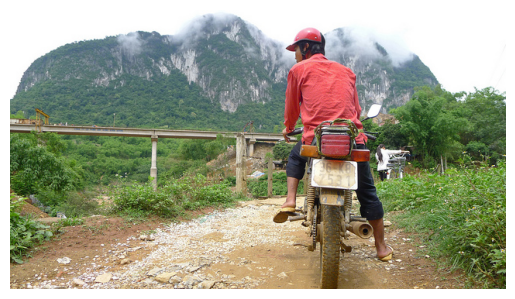

Does the image contain a mammal?
[{'role': 'system', 'content': [{'type': 'text', 'text': 'You are a helpful assistant.'}]}, {'role': 'user', 'content': [{'type': 'image', 'image': <PIL.Image.Image image mode=RGB size=640x360 at 0x79D471136430>}, {'type': 'text', 'text': 'Does the image contain a mammal?'}]}]


/home/anaconda3/envs/myo_thesis/lib/python3.9/site-packages/transformers/generation/configuration_utils.py:633: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.95` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
/home/anaconda3/envs/myo_thesis/lib/python3.9/site-packages/transformers/generation/configuration_utils.py:650: UserWarning: `do_sample` is set to `False`. However, `top_k` is set to `64` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_k`.
  warnings.warn(


Yes, the image contains a mammal. The person riding the motorcycle is a human, and humans are mammals.


In [56]:
import json
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

for index, row in df_reaonsing_questions.iterrows():
        reasoning_question = row['reasoning_question']
        # Load Image
        image_id = 391895
        image, image_info = loader.load_image(image_id)
        annotations = loader.get_annotations(image_id)

        plt.imshow(image)
        plt.axis('off')  # Hide axis
        plt.show()

        print(reasoning_question)
        answer = model(image = image,
                prompt = reasoning_question)
        print(answer)

        break

In [15]:
from datasets import load_dataset

# Load the dataset from Hugging Face Hub
dataset = load_dataset("myothiha/ontobench_coco", split="train", cache_dir="/mnt/synology/myothiha/HF_CACHE")

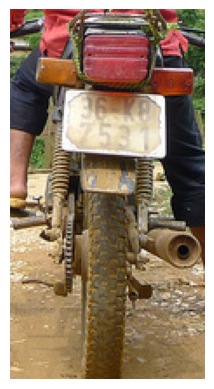

/home/anaconda3/envs/myo_thesis/lib/python3.9/site-packages/transformers/generation/configuration_utils.py:633: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.95` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
/home/anaconda3/envs/myo_thesis/lib/python3.9/site-packages/transformers/generation/configuration_utils.py:650: UserWarning: `do_sample` is set to `False`. However, `top_k` is set to `64` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_k`.
  warnings.warn(


Yes, the image contains a mammal. Specifically, it shows a person (a human, which is a mammal) sitting on the motorcycle. You can see the person's legs and torso.
Class: motorcycle | Q: Does the image contain a mammal? | A: yes | LLM: yes


In [ ]:
import matplotlib.pyplot as plt

# Iterate row-by-row
for example in dataset:
    image = example["image"]          # PIL Image object
    question = example["question"]
    answer = example["answer"]
    class_name = example["class_name"]

    # Example usage:
    plt.imshow(image)
    plt.axis('off')  # Hide axis
    plt.show()
    
    llm_answer = model(image = image,
                prompt = question)
    print(llm_answer)

    print(f"Class: {class_name} | Q: {question} | A: {answer} | LLM: {llm_answer}")

    break